In [31]:
import numpy as np
import os
import math as m
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, vectorize, int64, int32, float64, float32, cuda

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [20]:
@vectorize([float64(int32)])
def log(x):
    c = m.log(x)
    return c

@vectorize([float64(int32)])
def exp(x):
    c = m.exp(x)
    return c

A = np.array([2,5,10,3,8])
print("The logarithm of",A,"is:",log(A))
print("The exponential of",A,"is:",exp(A))

The logarithm of [ 2  5 10  3  8] is: [0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
The exponential of [ 2  5 10  3  8] is: [7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

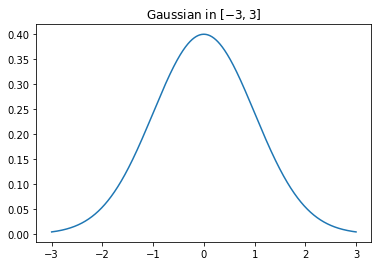

In [47]:
from math import pi
@vectorize([float64(float64)])
def gaussian(x):
    c = m.exp((-x**2)/2)/(m.sqrt(2*pi))
    return c

size = 100000
values = np.linspace(-3,3,size)
plt.plot(values,norm_gauss)
plt.title("Gaussian in $[-3,3]$")
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Time with 
162 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
270 µs ± 43 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.25 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


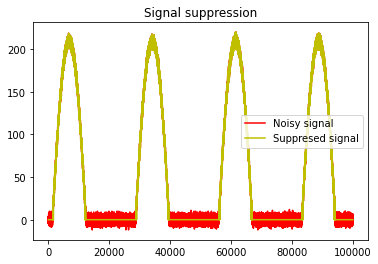

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

threshold = 15

plt.plot(data,'r',label='Noisy signal')

@jit
def zero_suppression(data,threshold):
    data[data<threshold] = 0
    return data

@jit
def loop_zero_suppression(data,threshold):
    for i in range(0,data.size):
        if data[i] < threshold: data[i] = 0
    return
        
@vectorize
def zero_suppression_per_element(x, threshold):
    if x<threshold: x = 0
    return x

# print("Time ")
%timeit zero_suppression(data,threshold)
%timeit loop_zero_suppression(data,threshold)
%timeit zero_suppression_per_element(data,threshold)

plt.plot(zero_suppresion(data,threshold),'y',label='Suppresed signal')
plt.legend(loc='best')
plt.title('Signal suppression')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [35]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(forceobj=True)
def sigmoid(X,Y,a,c):
    k = np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[0]):
            k[i,j] = m.tanh(a*sum(mul(X[:,i],Y[j,:]))+c)
    return k

@vectorize
def mul(x,y):
    return x*y

a = np.random.randint(0,10)
c = np.random.randint(0,10)

sig = sigmoid(X,Y,a,c)

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [38]:
@cuda.jit
def kernel_3d(mat):
    s1,s2,s3 = mat.shape
    a,b,c = cuda.grid(3)
    if a < s1 and b < s2 and c < s3:
        mat[a][b][c] = m.cos(mat[a][b][c])

# matr = np.random.rand(256,256,256) # In this case the running doesn't stop
matr = np.random.rand(32,32,32)

threadsperblock = (8,8,8)
blockspergrid_x = int(m.ceil(matr.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(matr.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(matr.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x,blockspergrid_y,blockspergrid_z)

print(matr)
kernel_3d[blockspergrid,threadsperblock](matr)
print("\n\n\n",matr)

[[[0.17620728 0.10683521 0.71802737 ... 0.3368698  0.16606014 0.98218846]
  [0.83838971 0.499768   0.06218028 ... 0.067991   0.62833245 0.82436165]
  [0.36824175 0.74413451 0.54579669 ... 0.14733979 0.41597444 0.09607251]
  ...
  [0.7661738  0.86521773 0.56929981 ... 0.4855532  0.68775765 0.53291394]
  [0.15222163 0.0515483  0.39205607 ... 0.46058309 0.54233161 0.66426466]
  [0.83655075 0.87401551 0.26638207 ... 0.98518449 0.29349577 0.17954568]]

 [[0.35406879 0.92965675 0.73123031 ... 0.24174633 0.61748606 0.88832226]
  [0.4295139  0.5605258  0.6453057  ... 0.22287168 0.90763079 0.40614326]
  [0.15482623 0.84445851 0.69725465 ... 0.7450046  0.89694491 0.4326404 ]
  ...
  [0.53017732 0.80324479 0.32946434 ... 0.10906823 0.80898444 0.3417678 ]
  [0.76423402 0.37890716 0.11004023 ... 0.38310819 0.13854265 0.69271211]
  [0.82737739 0.85267464 0.62597732 ... 0.02222651 0.6684074  0.12486732]]

 [[0.25930925 0.88853326 0.85128056 ... 0.47501663 0.46776057 0.99171449]
  [0.55145824 0.760406

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$

and that computes the multiplication and put the results into a third matrix C of shape $24x22$

A and B must be randomly generated and only int values are allowed.


In [15]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(0,100,size=(24,12))
B = np.random.randint(0,100,size=(12,22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (4,4)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x,blockspergrid_y)

matmul[threadsperblock,blockspergrid](A,B,C)
print(A,"\n",B,"\n",C)

[[48 15 10 30 58 46 87 27 35 10 70 99]
 [91 90 33 20  3  6 70 50 38 52 52 52]
 [ 0 40  3  7 72 38 74 87 71 45 70 12]
 [63 15 69 88 46 57 11  0 51 12 30 68]
 [28 58 48 35 87 49 24 10 35 64 94 91]
 [31 14 10 77 66 46 38 13  4 41 88 22]
 [58 43 51 10 81 99 31 73 13 62 42  5]
 [31 85 67 24 38 89  9 75 92 92 98 98]
 [48 58 94 22 40 97 99 66 17 78 62 31]
 [58 92 84  7 20 17 57 13 67 39 12 99]
 [ 1 80 72 52 49  9 65 58 82 52 24 30]
 [80 62 65 49  1 52 69 37 58 71 34 59]
 [94 97 95 89 71 13 84 72 25 57 46 66]
 [66 25  6 20 43 33 82  6 91 87 78 50]
 [91 42 22 30 51 39 17 42 51 71 25  2]
 [26 24 14 56 48 75  4 28 69 67 82  1]
 [70 16 34 79 54 64 92 70  4  2 88 28]
 [40 79 82 79  7 27 17 93 12 67 56 29]
 [41 94 92 34 69 72 83 82 63 13 53 96]
 [81  4 98  8 27 26 64 48  5 59 53 58]
 [44 83 91 86 41  4 83 46 37 72 91 80]
 [40 41 73 51 48 30  2 20 78 18 38 34]
 [14  3 10 31 43 27 78 91 82 91 17 16]
 [20 15 67 33 21 13 79 86 43 17 95 69]] 
 [[25 70 56 65  0 74  6 54 40 37 65 22  9 22 84 96 87 38 48 25